In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array


2025-02-06 17:36:28.535886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738874188.562193  236710 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738874188.570994  236710 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-06 17:36:28.600407: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
'''

%pip install scikit-learn
%pip install tensorflow==2.18.0
%pip install gputil
%pip install pandas
%pip install tqdm
%pip install matplotlib
'''


'\n\n%pip install scikit-learn\n%pip install tensorflow==2.18.0\n%pip install gputil\n%pip install pandas\n%pip install tqdm\n%pip install matplotlib\n'

In [3]:

import tensorflow as tf
# Verificar a versão do TensorFlow e a disponibilidade da GPU
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
import ctypes
import os


def find_cudnn():
    cudnn_path = ctypes.util.find_library('cudnn')
    if cudnn_path:
        print(f"cuDNN library found at: {cudnn_path}")
    else:
        print("cuDNN library not found")

find_cudnn()
import subprocess

def find_cudnn_path():
    try:
        # Executar o comando ldd no Python para listar as dependências
        result = subprocess.run(['ldd', '$(which python)'], capture_output=True, text=True, shell=True)
        # Filtrar a saída para encontrar o caminho do libcudnn.so.9
        for line in result.stdout.split('\n'):
            if 'libcudnn.so.9' in line:
                print(line)
    except Exception as e:
        print(f"Erro ao executar o comando ldd: {e}")

find_cudnn_path()

# Forçar o uso da CPU
tf.config.set_visible_devices([], 'GPU')
# Verificar a versão do TensorFlow e a disponibilidade da CPU
print("TensorFlow version:", tf.__version__)
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))


TensorFlow version: 2.18.0
Num GPUs Available:  1
cuDNN library found at: libcudnn.so.9
TensorFlow version: 2.18.0
Num CPUs Available:  1


In [4]:

# Ler o arquivo Dataset.csv
dataset_path = './Dataset.csv'
df = pd.read_csv(dataset_path)

# Dividir os dados em treino e teste
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Função para carregar as imagens e rótulos
def load_image(img_path):
    img = load_img(img_path, target_size=(160, 160))
    img_array = img_to_array(img)
    return img_array

def load_images_and_labels(df):
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = os.path.join('./Faces/Faces', row['id'])
        label = row['label']
        img_array = load_image(img_path)
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)

# Carregar as imagens e rótulos para treino e teste
X_train, y_train = load_images_and_labels(train_df)
X_test, y_test = load_images_and_labels(test_df)

# Codificar os rótulos
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# Criar o modelo
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Reduzir o tamanho do lote para evitar o erro de falta de memória
batch_size = 5

# Criar datasets do TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_categorical)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_categorical)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Treinar o modelo e obter o histórico
history = model.fit(train_dataset, validation_data=test_dataset, epochs=10)

# Avaliar o modelo
loss, accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {accuracy:.2f}')


Epoch 1/10


I0000 00:00:1738874226.605960  236922 service.cc:148] XLA service 0x7913200ac960 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738874226.605995  236922 service.cc:156]   StreamExecutor device (0): Host, Default Version
2025-02-06 17:37:07.619009: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738874242.825566  236922 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


410/410 ━━━━━━━━━━━━━━━━━━━━ 706s 2s/step - accuracy: 0.1904 - loss: 4.1855 - val_accuracy: 0.5478 - val_loss: 1.5343
Epoch 2/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 647s 2s/step - accuracy: 0.6616 - loss: 1.1315 - val_accuracy: 0.8070 - val_loss: 0.6903
Epoch 3/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 632s 2s/step - accuracy: 0.8874 - loss: 0.3732 - val_accuracy: 0.8129 - val_loss: 0.7163
Epoch 4/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 638s 2s/step - accuracy: 0.9455 - loss: 0.1681 - val_accuracy: 0.8304 - val_loss: 0.7467
Epoch 5/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 629s 2s/step - accuracy: 0.9434 - loss: 0.1806 - val_accuracy: 0.7446 - val_loss: 1.1032
Epoch 6/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 629s 2s/step - accuracy: 0.9526 - loss: 0.1734 - val_accuracy: 0.8051 - val_loss: 0.8647
Epoch 7/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 625s 2s/step - accuracy: 0.9390 - loss: 0.2278 - val_accuracy: 0.8343 - val_loss: 0.7024
Epoch 8/10
410/410 ━━━━━━━━━━━━━━━━━━━━ 633s 2s/step - accuracy: 0.9670 - loss: 0.1286 - val_accuracy: 0.758

In [5]:

# Salvar o modelo
model.save('face_recognition_model_batchSize5.keras')


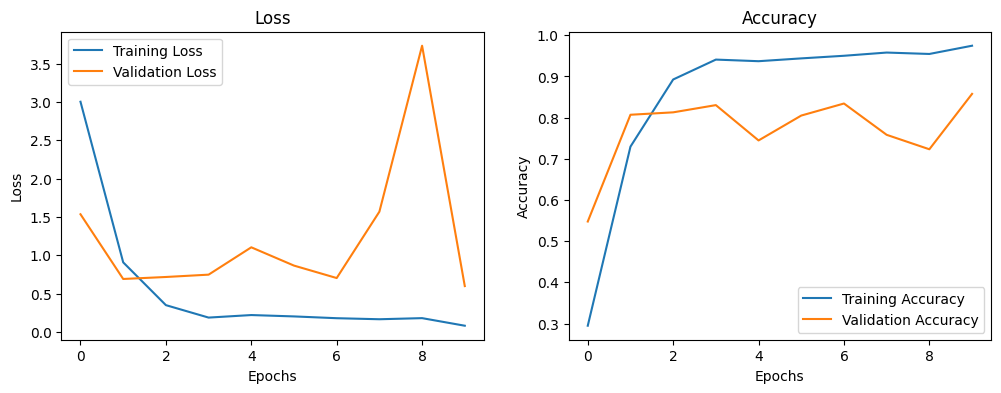

In [6]:

# Plotar o histórico de treinamento e validação
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()